# Object-oriented-programmed Neural Network

### Multiclass classification and softmax

In [7]:
import numpy as np
import matplotlib.pyplot as plt

We define several classes :
- a "net" class that will be instantiated only once
- several "layer" classes, which will have to be instantiated Keras-style.

Examples are vertical vectors, so the matrix Y representing the labels is of shape ```(number_of_classes, number_of_examples)```

In [66]:
def to_one_hot(M1):
    n_classes = 3
    M2 = np.zeros((n_classes, sample_size * 3))
    for i in range(n_classes * 3):
        M2[M1[i], i] = 1

def from_one_hot(M1):
    decoded = np.argmax(M1, axis=0)
    assert decoded.shape[1] == M1.shape[1]
    return decoded

In [96]:
class Net():
    
    def __init__(self, loss_type):
        self.layers = []
        self.loss_type = loss_type
        
    def add(self, layer):
        self.layers.append(layer)
        
    def forward_pass(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A

#     def multi_cross_entropy(self, preds, labels):
#         # preds: probabilities in a (nclasses, nexamples) array
#         # labels: 1-0 in a (nclasses, nexamples) array (one-hot encoded)
#         assert preds.shape == labels.shape
#         cross = np.multiply(preds, labels)
#         cross = cross[cross != 0]
#         cross = -np.log(cross)
#         cross = np.mean(cross)
#         return cross

    def multi_cross_entropy(self, preds, labels):
    
    logs = np.log()
    loss = - np.sum(log_likelihood) / m
    return loss
    
    def backward_pass(self, dERROR, learning_rate):
        backward_list = reversed(self.layers[0:-1])
        for layer in backward_list:
            dERROR = layer.backward(dERROR, learning_rate)

    def train(self, X, Y, learning_rate, epochs, prints_freq=0, plot=False):
        costs = []
        for epoch in range(epochs):
            A = self.forward_pass(X)
            dERROR = A - Y # at this point dERROR = dJ/dZ
            curr_cross_entropy = self.multi_cross_entropy(A, Y)
            costs.append(curr_cross_entropy)
            
            if prints_freq > 0:
                if epoch % prints_freq == 0:
                    print("Epoch:", epoch, "  Cost:", curr_cross_entropy)
                
            self.backward_pass(dERROR, learning_rate)
        
        if plot:
            plt.plot(costs)
        
    def get_accuracy(self, A, Y):
        # get best-guess predictions
        preds = np.argmax(A, axis=0)
#         print("preds", preds)
        flattened_Y = np.argmax(Y, axis=0)
#         print("flattened Y", flattened_Y)
        # check how many such guesses were right
        correct_preds = (flattened_Y == preds)
        n_correct = np.sum(correct_preds)
        # get accuracy rate
        m = A.shape[1] # number of examples
        accuracy = n_correct / m
        return accuracy

In [97]:
class LayerFC():    
    def __init__(self, n_x, n_h):
        self.W = np.random.randn(n_h, n_x)
        self.b = np.zeros((n_h, 1))
    def forward(self, A_prev):
        assert A_prev.shape[0] == self.W.shape[1]
        assert self.b.shape[0] == self.W.shape[0]
        self.A_prev = A_prev
        self.Z = np.dot(self.W, self.A_prev) + self.b
        return self.Z
    def backward(self, dERROR, learning_rate):
        m = dERROR.shape[1] #batch size
        dW = (1 / m) * np.dot(dERROR, self.A_prev.T)
        db = (1 / m) * np.sum(dERROR, axis=1, keepdims=True)
        assert self.W.shape[0] == dERROR.shape[0]        
        dERROR = np.dot(self.W.T, dERROR)
        self.W = self.W - learning_rate * dW        
        self.b = self.b - learning_rate * db                
        return dERROR
    
class LayerSigmoid():
    def forward(self, Z):
        self.A = 1 / (1 + np.exp(-Z))
        return self.A
    def backward(self, dERROR, learning_rate):
        derivative = self.A * (1 - self.A)
        assert derivative.shape == dERROR.shape
        dERROR = dERROR * derivative        
        return dERROR

class LayerTanh():    
    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A
    def backward(self, dERROR, learning_rate):
        derivative = 1 - np.square(self.A)
        assert derivative.shape == dERROR.shape
        dERROR = dERROR * derivative
        return dERROR

class LayerSoftmax():    
    def forward(self, Z):
        self.t = np.exp(Z)
        exps_sum = np.sum(self.t)
        self.A = self.t / exps_sum
        return self.A


#### Generating examples

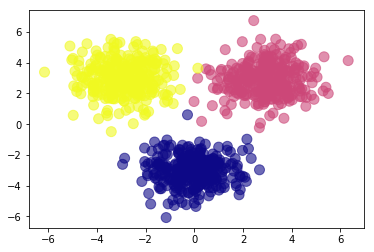

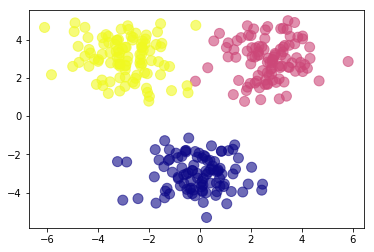

In [104]:
def gen_3plasma_zones(sample_size, show_dist=False):
    typeA = np.random.randn(sample_size, 2) + np.array([0, -3])
    typeB = np.random.randn(sample_size, 2) + np.array([3, 3])
    typeC = np.random.randn(sample_size, 2) + np.array([-3, 3])
    X = np.vstack([typeA, typeB, typeC]).T 
    
    Y_temp = np.array([0]*sample_size + [1]*sample_size + [2]*sample_size)
    Y = np.zeros((3, sample_size * 3))
    for i in range(sample_size * 3):
        Y[Y_temp[i], i] = 1

    if show_dist:
        plt.scatter(X[0, :], X[1, :], c=Y_temp, cmap='plasma', s=100, alpha=0.6)  
        plt.show()
    
    return X, Y, Y_temp

X_train_multi, Y_train_multi, _ = gen_3plasma_zones(300, True)
X_test_multi, Y_test_multi, _ = gen_3plasma_zones(100, True)

#### Training

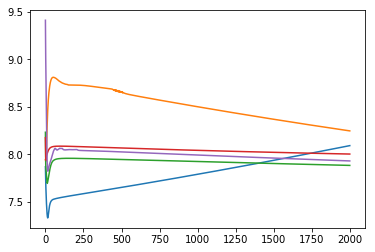

In [99]:
for i in range(5):
    net = Net('multi_cross_entropy')
    net.add(LayerFC(2,2))
    net.add(LayerTanh())
    net.add(LayerFC(2, 3))
    net.add(LayerTanh())
    net.add(LayerFC(3, 3))
    net.add(LayerTanh())
    net.add(LayerFC(3, 3))
    net.add(LayerSoftmax())

    net.train(X_train_multi, Y_train_multi, epochs=2000, learning_rate=0.11, prints_freq=0, plot=True)

In [102]:
net = Net('multi_cross_entropy')
net.add(LayerFC(2,2))
net.add(LayerTanh())
net.add(LayerFC(2, 3))
net.add(LayerTanh())
net.add(LayerFC(3, 3))
net.add(LayerTanh())
net.add(LayerFC(3, 3))
net.add(LayerSoftmax())

net.train(X_train_multi, Y_train_multi, epochs=1000, learning_rate=0.11, prints_freq=100)

Epoch: 0   Cost: 7.746973750863231
Epoch: 100   Cost: 8.221059161484455
Epoch: 200   Cost: 8.240879057067325
Epoch: 300   Cost: 8.238050087920183
Epoch: 400   Cost: 8.252753828707746
Epoch: 500   Cost: 8.185131436151604
Epoch: 600   Cost: 8.16423662224738
Epoch: 700   Cost: 8.147263041163955
Epoch: 800   Cost: 8.1307488147148
Epoch: 900   Cost: 8.114618718919434


In [103]:
r = net.forward_pass(X_test_multi)
net.get_accuracy(r, Y_test_multi)

0.6666666666666666

In [106]:
net.multi_cross_entropy(X_test_multi,X_test_multi)

-1.4755407747568132

In [ ]:
def MCE(preds, labels):

    logs = np.log()
    loss = - np.sum(log_likelihood) / m
    return loss


preds = [0.4, 0.2, 0.4]
label = [0, 1, 0]

MCE(preds, label) 

In [111]:
for i in reversed(range(11)):
    print(f"-log({i/10})   ", -np.log(i/10))
    

-log(1.0)    -0.0
-log(0.9)    0.10536051565782628
-log(0.8)    0.2231435513142097
-log(0.7)    0.35667494393873245
-log(0.6)    0.5108256237659907
-log(0.5)    0.6931471805599453
-log(0.4)    0.916290731874155
-log(0.3)    1.2039728043259361
-log(0.2)    1.6094379124341003
-log(0.1)    2.3025850929940455
-log(0.0)    inf


/home/guillaumeubuntu/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [144]:
preds = np.array([0.4, 0.2, 0.4],[0.4, 0.2, 0.4],[0.4, 0.2, 0.4], ndmin=2)
labels = np.array([0, 1, 0], ndmin=2)

In [147]:
def MCE1(A, Y):
    # p.shape(4, 1) / # K, 1 # mK, 1 # K, M 
    # l.shape(4, 1) / 
    prod = np.dot(A.T, Y)
    loss = - np.log(prod)
    return loss

def MCE2(A, Y):
    temp = np.multiply(A,Y)
    print('temp1', temp)
    temp = np.sum(temp, axis=0)
    print('temp2', temp)
    temp = - np.log(temp)
    print('temp3', temp)
    loss = 1 / A.shape[1] * np.sum(temp, axis=1)
    return loss

In [148]:
MCE2(preds, labels)

temp1 [[0.  0.2 0. ]]
temp2 [0.  0.2 0. ]
temp3 [       inf 1.60943791        inf]


/home/guillaumeubuntu/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


AxisError: axis 1 is out of bounds for array of dimension 1